# From text to models in World Modelers

## Choose text corpus to process

In [1]:
text = """The government promotes improved cultivar to boost agricultural production for ensuring food
security. However, the policy to seriously cut down the use of inorganic fertilizer and phase out
the fertilizer subsidy results in deteriorating biophysical conditions, low use of inorganic
fertilizer, less water, significantly reduced farm sizes which lead to low benefit from the
improved cultivar."""

## Read text via interface to Eidos system

In [2]:
from indra.sources import eidos
eidos_processor = eidos.process_text(text)

## De-duplicated INDRA Influence Statements

In [3]:
statements = eidos_processor.statements

In [4]:
import indra.tools.assemble_corpus as ac
statements = ac.run_preassembly(statements)

INFO: indra/assemble_corpus - Combining duplicates on 18 statements...
INFO: indra/assemble_corpus - 10 unique statements
INFO: indra/assemble_corpus - Combining related on 10 statements...
INFO: indra/preassembler - combine_related: poolsize not set, not using multiprocessing.
INFO: indra/preassembler - Preassembling Influence (10)
INFO: indra/preassembler - Groups: 10 parent, 0 worker
INFO: indra/preassembler - Done running parent process groups
INFO: indra/preassembler - Done.
INFO: indra/assemble_corpus - Filtering 10 statements for top-level...
INFO: indra/assemble_corpus - 10 statements after filter...
INFO: indra/assemble_corpus - 10 top-level statements


In [5]:
statements

[Influence(agricultural production(positive), food security()),
 Influence(biophysical conditions(negative), benefit()),
 Influence(cultivar(positive), agricultural production(positive)),
 Influence(cultivar(positive), benefit()),
 Influence(farm sizes(negative), benefit()),
 Influence(government(), agricultural production(positive)),
 Influence(government(), cultivar(positive)),
 Influence(policy(), biophysical conditions(negative)),
 Influence(use of inorganic fertilizer(), farm sizes(negative)),
 Influence(water(negative), farm sizes(negative))]

## Assemble into graph and visualize

In [6]:
from indra.assemblers import GraphAssembler
ga = GraphAssembler(statements)
ga.make_model()
ga.save_pdf('model_graph.pdf')

In [7]:
from IPython.display import IFrame
IFrame("model_graph.pdf", width=600, height=500)

## Assemble into a system of ODEs and simulate

In [8]:
from indra.assemblers import PysbAssembler
from pysb.simulator import ScipyOdeSimulator; import numpy; import matplotlib.pyplot as plt; plt.ion()

In [9]:
pa = PysbAssembler()
pa.add_statements(statements)
model = pa.make_model()

In [10]:
import numpy
ts = numpy.linspace(0, 50000)
sim = ScipyOdeSimulator(model, ts)

In [11]:
res = sim.run()

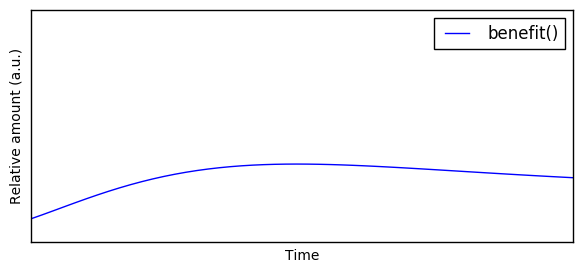

In [17]:
plt.figure(figsize=(7,3))
plt.xlim(0, 50000)
plt.ylim(0, 100000)
plt.xlabel('Time')
plt.ylabel('Relative amount (a.u.)')
plt.xticks([])
plt.yticks([])
for i, cp in enumerate(model.species):
    if str(cp) == 'benefit()':
        plt.plot(ts, res.all['__s%d' % i], label=str(cp))
plt.legend()

## Assemble into a Bayesian Network represented as a Figaro model

In [18]:
from indra.assemblers import FigaroAssembler

In [19]:
fa = FigaroAssembler(statements, readout='benefit')

In [20]:
fa.make_model()

In [21]:
print(fa.print_model('IndraModel.scala'))

import com.cra.figaro.language._
import com.cra.figaro.library.atomic._
import com.cra.figaro.library.compound._
import com.cra.figaro.library.atomic.continuous.Normal
import com.cra.figaro.algorithm.sampling.Importance

object IndraModel {
val biophysical_conditions = Chain(policy, (v:Double) => Normal(v, 0.2))
val benefit = Chain(^^(biophysical_conditions,cultivar,farm_sizes), (v:(Double,Double,Double)) => Normal(+ 1.00 * v._1 + 1.00 * v._2 + 1.00 * v._3, 0.2))
val government = Normal(1,0.2)
val cultivar = Chain(government, (v:Double) => Normal(v, 0.2))
val policy = Normal(1,0.2)
val agricultural_production = Chain(^^(government,cultivar), (v:(Double,Double)) => Normal(+ 1.00 * v._1 + 1.00 * v._2, 0.2))
val use_of_inorganic_fertilizer = Normal(1,0.2)
val farm_sizes = Chain(^^(use_of_inorganic_fertilizer,water), (v:(Double,Double)) => Normal(+ 1.00 * v._1 + 1.00 * v._2, 0.2))
val water = Normal(1,0.2)
val food_security = Chain(agricultural_production, (v:Double) => Normal(v, 0.2))
def